In [1]:
%pylab inline
import json
import math
import string
import numpy as np
import pandas as pd
import scipy.stats as stats
from suffix_tree import SuffixTree
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr

Populating the interactive namespace from numpy and matplotlib


In [52]:
path = './'
colfilejson = path + 'itp_col_seq.json'
indfilejson = path + 'dataset_coopometro_livorno_prov_itp_all.json'

In [53]:
# Read col seq
data = open(colfilejson, 'r')
col_seq = dict()
for row in data:
    itp = json.loads(row.rstrip('\n'))
    col_seq[itp['customer_id']] = itp['col_pattern_seq']
data.close()

In [54]:
# Read individual temporal profiles
data = open(indfilejson, 'r')

ind_seq = dict()
nbr_pattern = dict()
psize_pattern = dict()
pur_pattern = dict()
ent_pattern = dict()

for row in data:
    try:
        itp = json.loads(row.rstrip('\n'))
        customer_id = itp['customer_id']
        ind_seq[customer_id] = itp['pattern_seq']
        nbr_pattern[customer_id] = itp['npatterns']
        psize_pattern[customer_id] = itp['patterns_size']
        pur_pattern[customer_id] = purity(itp['patterns_size'].values())
        ent_pattern[customer_id] = entropy(itp['patterns_size'].values(), classes=len(itp['patterns_size'].values()))
    except:
        continue
data.close()

In [55]:
def purity(values):
    return 1.0 * np.max(values) / np.sum(values)

In [56]:
def entropy(x, classes=None):
    val_entropy = 0
    n = np.sum(x)
    for freq in x:
        if freq == 0:
            continue
        p = 1.0 * freq / n
        val_entropy -= p * np.log2(p)
    if classes is not None:
        val_entropy /= np.log2(classes)
    return val_entropy

In [57]:
num2alpha = dict(zip(range(0, 26), string.ascii_lowercase))
alpha2num = dict(zip(string.ascii_lowercase, range(0, 26)))
num2alpha_col = dict(zip(range(0, len(string.ascii_letters)), string.ascii_letters))
alpha2num_col = dict(zip(string.ascii_letters, range(0, len(string.ascii_letters))))

In [58]:
customer_ind2col = dict()
for customer_id in ind_seq:
    ind2col = dict()
    for i,c in zip(ind_seq[customer_id], col_seq[customer_id]):
        ind2col[i] = c
    customer_ind2col[customer_id] = ind2col

In [59]:
col_nbr_pattern = dict()
col_psize_pattern = dict()
col_pur_pattern = dict()
col_ent_pattern = dict()

for customer_id in customer_ind2col:
    col_nbr_pattern[customer_id] = len(set(customer_ind2col[customer_id].values()))
    col_psize_pattern[customer_id] = dict()
    for pattern_id in psize_pattern[customer_id]:
        col_pattern_id = customer_ind2col[customer_id][num2alpha[int(pattern_id)]]
        if alpha2num_col[col_pattern_id] not in col_psize_pattern[customer_id]:
            col_psize_pattern[customer_id][alpha2num_col[col_pattern_id]] = 0
        col_psize_pattern[customer_id][alpha2num_col[col_pattern_id]] += psize_pattern[customer_id][pattern_id]
        col_pur_pattern[customer_id] = purity(col_psize_pattern[customer_id].values())
        col_ent_pattern[customer_id] = entropy(col_psize_pattern[customer_id].values(), 
                                               classes=len(col_psize_pattern[customer_id].values()))

In [60]:
psize_pattern[customer_id], col_psize_pattern[customer_id]

({u'0': 21,
  u'1': 39,
  u'2': 23,
  u'3': 36,
  u'4': 29,
  u'5': 22,
  u'6': 21,
  u'7': 63},
 {1: 36, 14: 22, 21: 29, 24: 21, 25: 23, 28: 21, 29: 63, 31: 39})

In [61]:
fileclustering = '/Users/riccardo/Documents/PhD/Cooppometro/cooppometro/experiments/20160419_dsaa/img/k-means_cosine_filt/'
fileclustering += 'cosine_distance_filt_customers2cluster.csv'

In [62]:
df = pd.read_csv(fileclustering, sep=';', skipinitialspace=True)

In [63]:
customers = df['customer_id'].unique()
tot_collective = len(df['label'].unique())

In [64]:
random_collective_list_all = list()
for customer_id in sorted(customers):
    df_ind = df[df['customer_id'] == customer_id]
    ndistinctive = len(df_ind['profile_id'].unique())
    collective_list = list(df_ind['label'].unique())
    ncollective = len(collective_list)
    
    random_collective_list = np.random.choice(range(0, tot_collective), size=ndistinctive, replace=True)
    nrandom_collective = len(set(random_collective_list))
    
    #print customer_id, ndistinctive, ncollective, nrandom_collective
    random_collective_list_all.append(nrandom_collective)

In [65]:
random_collective_list_all[:10]

[5, 12, 8, 8, 6, 7, 8, 5, 5, 8]

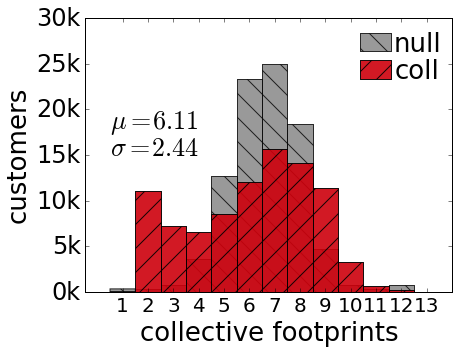

In [66]:
fig, ax = plt.subplots(figsize=(6, 5))
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.14)

set_nbr_patterns = set(col_nbr_pattern.values())
nbr_diff_nbr_patterns = len(set_nbr_patterns)

plt.hist(random_collective_list_all, bins=range(min(set_nbr_patterns)-1,nbr_diff_nbr_patterns,1), 
         color='gray', alpha=0.8, hatch='\\', label='null')
plt.hist(col_nbr_pattern.values(), bins=range(min(set_nbr_patterns)-1,nbr_diff_nbr_patterns,1), 
         color='#ce000c', alpha=0.9, hatch='/', label='coll')
plt.ylabel('customers', fontsize=26)
plt.xlabel('collective footprints', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.xticks(np.asarray(range(min(set_nbr_patterns)-1,nbr_diff_nbr_patterns + 1,1)) + 0.5, 
           range(min(set_nbr_patterns)-1,nbr_diff_nbr_patterns,1), fontsize=20)
plt.yticks(np.arange(0,35000,5000), ['%dk' % (v/1000.0) for v in np.arange(0,35000,5000)])

plt.text(1, 18000, r'$\mu=%.2f$' % np.mean(col_nbr_pattern.values()), fontsize=26)
plt.text(1, 15000, r'$\sigma=%.2f$' % np.std(col_nbr_pattern.values()), fontsize=26)

plt.legend(loc='best', fontsize=26, ncol=1, columnspacing=0.2, labelspacing=0.05,
           handlelength=1.2, borderpad=0, handletextpad=0.2, frameon=False)

path_plot = './'
plt.savefig(path_plot + 'col_dist_cf.png', format='png', bbox_inches='tight')

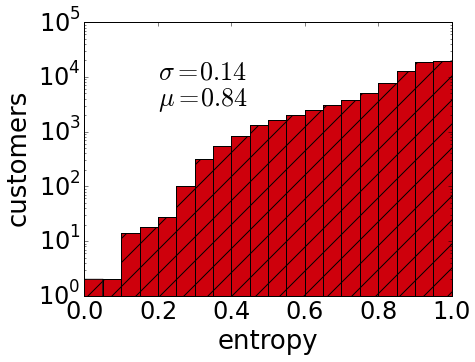

In [322]:
fig, ax = plt.subplots(figsize=(6, 5))
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.14)

values = list()
for v in col_ent_pattern.values():
    if str(v) != 'nan':
        values.append(v)
plt.hist(values, bins=np.arange(0.0, 1.05, 0.05), color='#ce000c', hatch='/')
plt.ylabel('customers', fontsize=26)
plt.xlabel('entropy', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.yscale('log')
plt.xlim([0,1])

plt.text(0.2, 10**3+2*10**3, r'$\mu=%.2f$' % np.mean(values), fontsize=26)
plt.text(0.2, 10**3+8*10**3, r'$\sigma=%.2f$' % np.std(values), fontsize=26)

path_plot = './'
plt.savefig(path_plot + 'col_dist_ent.png', format='png', bbox_inches='tight')

In [177]:
from scipy.optimize import curve_fit

def fun(x, a, b):
    return b * np.power(x, a)

values = list()
for v in col_ent_pattern.values():
    if str(v) != 'nan':
        values.append(v)
        
val, bins = np.histogram(values, bins=np.arange(0, 1.05, 0.05))
xdata = bins[1:]
ydata = val
curve_fit_opt, _ = curve_fit(fun, xdata, ydata)
print curve_fit_opt[0], curve_fit_opt[1]

5.25358717072 20899.0302897


In [179]:
fun(0.9, 5.25358717072, 20899.0302897)

12015.31525038381

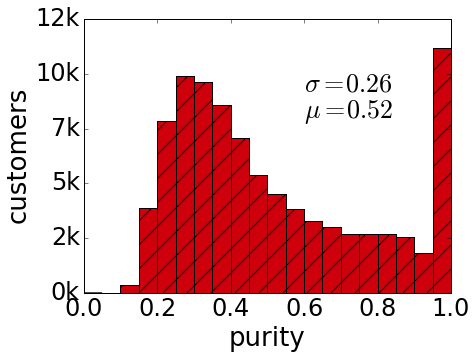

In [323]:
fig, ax = plt.subplots(figsize=(6, 5))
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.14)

plt.hist(col_pur_pattern.values(), bins=np.arange(0.0, 1.05, 0.05), color='#ce000c', hatch='/')
plt.ylabel('customers', fontsize=26)
plt.xlabel('purity', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=24)
#plt.yscale('log')
#plt.xlim([0,1])
plt.yticks(np.arange(0,15000,2500), ['%dk' % (v/1000.0) for v in np.arange(0,15000,2500)])

plt.text(0.6, 8000, r'$\mu=%.2f$' % np.mean(col_pur_pattern.values()), fontsize=26)
plt.text(0.6, 9200, r'$\sigma=%.2f$' % np.std(col_pur_pattern.values()), fontsize=26)

path_plot = './'
plt.savefig(path_plot + 'col_dist_pur.png', format='png', bbox_inches='tight')

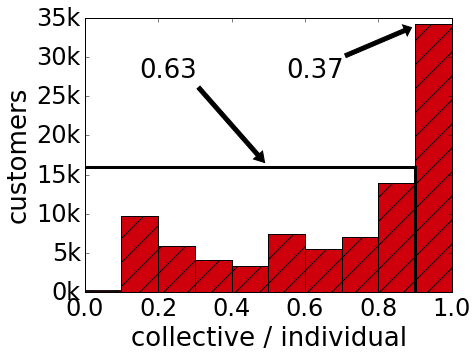

In [67]:
fig, ax = plt.subplots(figsize=(6, 5))
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.14)

#plt.hexbin(nbr_pattern.values(), col_nbr_pattern.values(), cmap='Reds')
#plt.scatter(nbr_pattern.values(), col_nbr_pattern.values())
values = list()
count_ones = 0
count_less = 0
ratio_col_ind = dict()
for customer_id in nbr_pattern:
    v = 1.0*(col_nbr_pattern[customer_id]-1)/nbr_pattern[customer_id]
    values.append(v)
    if v == 1.0:
        count_ones += 1
    else:
        count_less += 1
    ratio_col_ind[customer_id] = v
plt.hist(values, bins=np.arange(0.0, 1.1, 0.1), color='#ce000c', hatch='/')
plt.ylabel('customers', fontsize=26)
plt.xlabel('collective / individual', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.yticks(np.arange(0,40000,5000), ['%dk' % (v/1000.0) for v in np.arange(0,50000,5000)])

plt.axvline(x=0.9, ymin=0, ymax=0.45, linewidth=3, color='k')
plt.axhline(y=16000, xmin=0, xmax=0.9, linewidth=3, color='k')

plt.annotate('%.2f' % (1.0*count_less/(count_less + count_ones)), xy=(0.5, 16000), xycoords='data',
                xytext=(0.3, 30000), fontsize=26,
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='right', verticalalignment='top',
                )

plt.annotate('%.2f' % (1.0*count_ones/(count_less + count_ones)), xy=(0.9, 34000), xycoords='data',
                xytext=(0.7, 30000), fontsize=26,
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='right', verticalalignment='top',
                )

path_plot = './'
plt.savefig(path_plot + 'ind_col_dist_dcf.png', format='png', bbox_inches='tight')

In [17]:
regular_customers = list()
changing_customers = list()
for customer_id, val in col_nbr_pattern.iteritems():
    if val <= 4:
        regular_customers.append(customer_id)
    else:
        changing_customers.append(customer_id)

In [18]:
len(regular_customers), len(changing_customers)

(24899, 66065)

In [31]:
regular_footprints = defaultdict(int)
for customer_id in regular_customers:
    for pattern_id in col_psize_pattern[customer_id]:
        regular_footprints[pattern_id] += 1 #col_psize_pattern[customer_id][pattern_id]

In [32]:
changing_footprints = defaultdict(int)
for customer_id in changing_customers:
    for pattern_id in col_psize_pattern[customer_id]:
        changing_footprints[pattern_id] += 1 #col_psize_pattern[customer_id][pattern_id]

In [33]:
len(regular_footprints), len(changing_footprints)

(46, 46)

In [34]:
purity(regular_footprints.values()), purity(changing_footprints.values())

(0.5227603546380839, 0.1330928132503833)

In [35]:
entropy(regular_footprints.values(), 46), entropy(changing_footprints.values(), 46)

(0.53411450352149847, 0.90137708877395206)

In [39]:
from scipy.stats import kendalltau

In [41]:
kendalltau(sorted(regular_footprints, key=regular_footprints.get, reverse=True), sorted(changing_footprints, key=changing_footprints.get, reverse=True))

KendalltauResult(correlation=-0.095652173913043495, pvalue=0.34858009182473904)

In [42]:
sorted(regular_footprints, key=regular_footprints.get, reverse=True)[:10]

[29, 1, 38, 0, 4, 24, 28, 31, 25, 43]

In [44]:
sorted(changing_footprints, key=changing_footprints.get, reverse=True)[:10]

[29, 1, 14, 21, 31, 25, 4, 24, 19, 28]

In [200]:
import pickle
pickle_file = open(path + 'regular_customers.pkl', 'w')
pickle.dumps(regular_customers)
pickle_file.close()

pickle_file = open(path + 'changing_customers.pkl', 'w')
pickle.dumps(changing_customers)
pickle_file.close()

In [203]:
path = './'
filename = path + 'dataset_coopometro_livorno_prov_filtered_iqr.csv'
#input_file='../data/dataset_coopometro_livorno_prov_filtered_iqr.csv.tar.gz'
df=pd.read_csv(filename, sep=';')

In [204]:
df.head()

,customer_id,negozio_id,scontrino_id,anno,mese,giorno,ora,giorno_settimana,settimana_anno,quantita,importo
0,13,75,1114075078865,2008,1,19,12,6,3,1,28
1,13,75,1054075073181,2007,11,20,12,2,47,10,19
2,13,75,1263075035868,2008,6,16,12,1,24,13,22
3,13,75,2128075094470,2010,10,29,13,5,44,14,43
4,13,75,1381075063685,2008,10,12,12,7,41,9,15


In [20]:
regular_tot_amount = defaultdict(list)
changing_tot_amount = defaultdict(list)
temp_dict = {k: 0 for k in regular_customers}
for row in df.iterrows():
    customer_id = row[1]['customer_id']
    importo = float(row[1]['importo'])
    if customer_id in temp_dict:
        regular_tot_amount[customer_id].append(importo)
    else:
        changing_tot_amount[customer_id].append(importo)

KeyError: 'importo'

In [294]:
regular_std = dict()
for customer_id in regular_tot_amount:
    regular_std[customer_id] = calculate_aggregate(regular_tot_amount[customer_id])['std']

In [295]:
changing_std = dict()
for customer_id in changing_tot_amount:
    changing_std[customer_id] = calculate_aggregate(changing_tot_amount[customer_id])['std']

In [279]:
regular_tot_amount_sum = dict()
for customer_id in regular_tot_amount:
    regular_tot_amount_sum[customer_id] = np.sum(regular_tot_amount[customer_id])

In [280]:
changing_tot_amount_sum = dict()
for customer_id in changing_tot_amount:
    changing_tot_amount_sum[customer_id] = np.sum(changing_tot_amount[customer_id])

In [296]:
calculate_aggregate(regular_std.values())

{'10p': 6.2129624829473116,
 '25p': 8.3965522998985396,
 '50p': 11.572149689556388,
 '75p': 16.013318591232519,
 '90p': 22.032645294822146,
 'avg': 19.308760467925207,
 'cov': 0.22188700150508953,
 'gin': 0.50116307555930706,
 'iqm': 11.754054765031423,
 'iqr': 7.6167662913339793,
 'kur': 6515.371805514109,
 'mad': 14.385104697642952,
 'med': 11.572149689556388,
 'skw': 68.31218118046378,
 'std': 87.020692230510463,
 'var': 7572.6008762772244}

In [297]:
calculate_aggregate(changing_std.values())

{'10p': 16.544095981047271,
 '25p': 22.940148300314103,
 '50p': 35.146531215311981,
 '75p': 55.32553209044675,
 '90p': 82.415432578085216,
 'avg': 44.042466513384568,
 'cov': 1.3079697234488241,
 'gin': 0.34693876928566836,
 'iqm': 36.430282500703314,
 'iqr': 32.38538379013265,
 'kur': 1592.2026582580263,
 'mad': 22.228741483810893,
 'med': 35.146531215311981,
 'skw': 17.584581808743664,
 'std': 33.672389906132089,
 'var': 1133.8298419905861}

In [221]:
np.sum(regular_tot_amount.values())/len(regular_tot_amount)

14189.756737218362

In [222]:
np.sum(changing_tot_amount.values())/len(changing_tot_amount)

24014.350557750229

In [224]:
len(regular_tot_amount), len(changing_tot_amount)

(24899, 66069)

In [262]:
col_psize_pattern[262146]

{1: 111, 29: 193}

In [19]:
regular_psize = defaultdict(int)
regular_cfootprints = defaultdict(int)
regular_purity = dict()
regular_entropy = dict()
for customer_id in regular_tot_amount:
    regular_purity[customer_id] = col_pur_pattern[customer_id]
    if col_ent_pattern[customer_id] is not np.nan:
        regular_entropy[customer_id] = col_ent_pattern[customer_id]
    
    regular_psize[customer_id] += np.sum(col_psize_pattern[customer_id].values())
    for cf in col_psize_pattern[customer_id]:
        regular_cfootprints[cf] += col_psize_pattern[customer_id][cf]
    

NameError: name 'regular_tot_amount' is not defined

In [264]:
changing_psize = defaultdict(int)
changing_cfootprints = defaultdict(int)

changing_purity = dict()
changing_entropy = dict()
for customer_id in changing_tot_amount:
    if customer_id in col_pur_pattern:
        changing_purity[customer_id] = col_pur_pattern[customer_id]
        changing_entropy[customer_id] = col_ent_pattern[customer_id]
        
        changing_psize[customer_id] += np.sum(col_psize_pattern[customer_id].values())
        for cf in col_psize_pattern[customer_id]:
            changing_cfootprints[cf] += col_psize_pattern[customer_id][cf]

In [265]:
for k in sorted(regular_cfootprints, key=regular_cfootprints.get, reverse=True)[:10]:
    print k, regular_cfootprints[k]

29 5134908
38 329327
1 233939
50 77421
0 69674
4 37942
24 33307
31 31180
25 29096
14 26532


In [266]:
for k in sorted(changing_cfootprints, key=changing_cfootprints.get, reverse=True)[:10]:
    print k, changing_cfootprints[k]

29 4369471
1 824030
14 654215
21 599280
31 589046
25 567405
24 554654
4 506156
0 447928
2 444492


(array([   20.,   411.,  1071.,  1572.,  1802.,  1826.,  1795.,  1666.,
         1541.,  1310.,  1205.,  1083.,   898.,   828.,   781.,   709.,
          577.,   551.,   458.,   436.,   388.,   350.,   303.,   273.,
          230.,   212.,   192.,   161.,   159.,   150.,   123.,   128.,
          126.,    90.,    96.,    85.,    57.,    80.,    67.,    70.,
           38.,    45.,    52.,    34.,    33.,    30.,    30.,    27.,
           25.]),
 array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
         9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
        18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000,
        27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000,
        36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000,
        45000, 46000, 47000, 48000, 49000]),
 <a list of 49 Patch objects>)

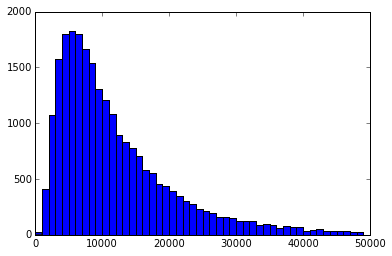

In [292]:
plt.hist(regular_tot_amount_sum.values(), bins=np.arange(0, 50000, 1000))
#plt.yscale('log')

(array([  1.00000000e+00,   1.01000000e+02,   5.19000000e+02,
          1.11800000e+03,   1.65300000e+03,   1.93600000e+03,
          2.28300000e+03,   2.48300000e+03,   2.48500000e+03,
          2.48300000e+03,   2.41000000e+03,   2.31600000e+03,
          2.26200000e+03,   2.16100000e+03,   2.04600000e+03,
          2.01300000e+03,   1.88300000e+03,   1.80400000e+03,
          1.71000000e+03,   1.55800000e+03,   1.58700000e+03,
          1.48700000e+03,   1.44300000e+03,   1.41000000e+03,
          1.26400000e+03,   1.24400000e+03,   1.14900000e+03,
          1.16000000e+03,   1.03300000e+03,   1.02600000e+03,
          9.42000000e+02,   8.78000000e+02,   8.72000000e+02,
          8.25000000e+02,   7.96000000e+02,   6.97000000e+02,
          7.53000000e+02,   6.31000000e+02,   6.12000000e+02,
          5.86000000e+02,   5.54000000e+02,   5.33000000e+02,
          4.73000000e+02,   5.39000000e+02,   4.52000000e+02,
          4.35000000e+02,   4.05000000e+02,   3.76000000e+02,
        

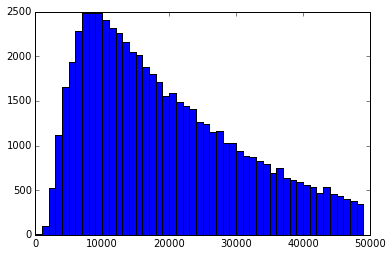

In [293]:
plt.hist(changing_tot_amount_sum.values(), bins=np.arange(0, 50000, 1000))
#plt.yscale('log')

In [225]:
from calculate_aggregate_statistics import *

In [281]:
calculate_aggregate(regular_tot_amount_sum.values())

{'10p': 3646.6000000000004,
 '25p': 5734.5,
 '50p': 9544.0,
 '75p': 16267.0,
 '90p': 26623.600000000002,
 'avg': 14189.756737218362,
 'cov': 0.61343131201003243,
 'gin': 0.46126574661544484,
 'iqm': 10018.950598441643,
 'iqr': 10532.5,
 'kur': 1301.2140548618856,
 'mad': 9431.1601129569917,
 'med': 9544.0,
 'skw': 25.637787627995277,
 'std': 23131.777689539093,
 'var': 535079139.07825851}

In [283]:
calculate_aggregate(changing_tot_amount_sum.values())

{'10p': 6578.0,
 '25p': 10589.0,
 '50p': 18633.0,
 '75p': 31670.0,
 '90p': 48231.000000000044,
 'avg': 24014.350557750229,
 'cov': 1.2354871272527208,
 'gin': 0.39931112863088036,
 'iqm': 19420.540289381282,
 'iqr': 21081.0,
 'kur': 49.36870353459497,
 'mad': 13972.654734085118,
 'med': 18633.0,
 'skw': 3.194764978969885,
 'std': 19437.151572068185,
 'var': 377802861.23555273}

In [260]:
calculate_aggregate(random.choice(changing_tot_amount.values(), size=len(regular_tot_amount)))

{'10p': 6548.8000000000002,
 '25p': 10581.0,
 '50p': 18586.0,
 '75p': 31479.5,
 '90p': 48196.60000000002,
 'avg': 23916.170810072694,
 'cov': 1.2532434405548267,
 'gin': 0.39958023311754298,
 'iqm': 19326.487873433987,
 'iqr': 20898.5,
 'kur': 9.494238331230383,
 'mad': 13932.154996643081,
 'med': 18586.0,
 'skw': 2.1929699531150693,
 'std': 19083.419897641517,
 'var': 364176914.9897002}

In [236]:
calculate_aggregate(regular_purity.values())

{'10p': 0.67010309278350511,
 '25p': 0.78719810235767684,
 '50p': 0.90990990990990994,
 '75p': 1.0,
 '90p': 1.0,
 'avg': 0.87666943626046112,
 'cov': 6.1969541502563406,
 'gin': 0.085576181455921718,
 'iqm': 0.94452705375435031,
 'iqr': 0.21280189764232316,
 'kur': 0.28637714333865594,
 'mad': 0.11778036442792345,
 'med': 0.90990990990990994,
 'skw': -1.0100511745317706,
 'std': 0.14146779450098032,
 'var': 0.020013136880971595}

In [315]:
calculate_aggregate(changing_purity.values())

{'10p': 0.21612903225806451,
 '25p': 0.27243589743589741,
 '50p': 0.35751295336787564,
 '75p': 0.47096774193548385,
 '90p': 0.59639561157542254,
 'avg': 0.38315202161748579,
 'cov': 2.6712672182299055,
 'gin': 0.20951050714994568,
 'iqm': 0.36201904925800205,
 'iqr': 0.19853184449958644,
 'kur': -0.11941855904654064,
 'mad': 0.11628536611326634,
 'med': 0.35751295336787564,
 'skw': 0.6876634628760263,
 'std': 0.14343455383373382,
 'var': 0.020573471233482288}

In [ ]:
regular_entropy.values()

In [316]:
x = np.asarray(regular_entropy.values())
calculate_aggregate(x[~numpy.isnan(x)])

{'10p': 0.42784139097608365,
 '25p': 0.51879842081493599,
 '50p': 0.63261318527004018,
 '75p': 0.76110671917117867,
 '90p': 0.87762376587438806,
 'avg': 0.64140186918863662,
 'cov': 3.8271889466830111,
 'gin': 0.14908124659681476,
 'iqm': 0.63505637882506039,
 'iqr': 0.24230829835624268,
 'kur': -0.5396977156084506,
 'mad': 0.13719939474628673,
 'med': 0.63261318527004018,
 'skw': 0.0895192874479557,
 'std': 0.167590855357307,
 'var': 0.028086694799393797}

In [317]:
calculate_aggregate(changing_entropy.values())

{'10p': 0.75640553649440923,
 '25p': 0.84731558459784839,
 '50p': 0.91246368892484986,
 '75p': 0.95509348047121645,
 '90p': 0.97858947106820815,
 'avg': 0.88701074008954939,
 'cov': 9.4774191813424213,
 'gin': 0.054897049996073366,
 'iqm': 0.90903645087830731,
 'iqr': 0.10777789587336806,
 'kur': 3.265754529116811,
 'mad': 0.070894747604065014,
 'med': 0.91246368892484986,
 'skw': -1.5660543524856934,
 'std': 0.093592013091048004,
 'var': 0.0087594649144349009}

In [268]:
calculate_aggregate(regular_psize.values())

{'10p': 112.0,
 '25p': 172.5,
 '50p': 257.0,
 '75p': 338.0,
 '90p': 379.0,
 'avg': 250.70922527009117,
 'cov': 2.5767037496063301,
 'gin': 1.0000401622555122,
 'iqm': 255.98443642198154,
 'iqr': 165.5,
 'kur': -1.0699711116278001,
 'mad': 83.572053287336743,
 'med': 257.0,
 'skw': -0.22476202220617128,
 'std': 97.29842839262939,
 'var': 9466.9841676756296}

In [267]:
calculate_aggregate(changing_psize.values())

{'10p': 88.0,
 '25p': 138.0,
 '50p': 219.0,
 '75p': 312.0,
 '90p': 367.0,
 'avg': 223.35286460304246,
 'cov': 2.2105448967039383,
 'gin': 1.0000151366078862,
 'iqm': 220.88488169064965,
 'iqr': 174.0,
 'kur': -1.168601613209599,
 'mad': 87.262936104297523,
 'med': 219.0,
 'skw': 0.03350499046215719,
 'std': 101.03973230133244,
 'var': 10209.027503524921}

In [250]:
amount = list()
purity = list()
entropy = list()
for customer_id in regular_tot_amount:
    if ~numpy.isnan(regular_entropy[customer_id]):
        amount.append(regular_tot_amount[customer_id])
        purity.append(regular_purity[customer_id])
        entropy.append(regular_entropy[customer_id])


In [251]:
pearsonr(amount, purity), pearsonr(amount, entropy)

((-0.24418426172222435, 6.5644219408358763e-187),
 (0.26468600127399222, 1.898764738359311e-220))

In [253]:
amount = list()
purity = list()
entropy = list()
for customer_id in changing_tot_amount:
    if customer_id in changing_entropy and ~numpy.isnan(changing_entropy[customer_id]):
        amount.append(changing_tot_amount[customer_id])
        purity.append(changing_purity[customer_id])
        entropy.append(changing_entropy[customer_id])
pearsonr(amount, purity), pearsonr(amount, entropy)

((-0.2857000144918912, 0.0), (0.25767485806693435, 0.0))

In [301]:
regular_raio = list()
changing_ratio = list()
for customer_id in regular_tot_amount:
    regular_raio.append(ratio_col_ind[customer_id])
for customer_id in changing_tot_amount:
    if customer_id in ratio_col_ind:
        changing_ratio.append(ratio_col_ind[customer_id])

In [303]:
calculate_aggregate(regular_raio)

{'10p': 0.125,
 '25p': 0.14285714285714285,
 '50p': 0.25,
 '75p': 0.375,
 '90p': 0.5,
 'avg': 0.27353111989241946,
 'cov': 1.8846672396682218,
 'gin': 0.28883461108802522,
 'iqm': 0.24103954329352087,
 'iqr': 0.23214285714285715,
 'kur': 1.1654631174958903,
 'mad': 0.12011277863911354,
 'med': 0.25,
 'skw': 1.0182676065280554,
 'std': 0.14513496819766022,
 'var': 0.021064158993735847}

In [305]:
calculate_aggregate(changing_ratio), len(changing_ratio)

({'10p': 0.625,
  '25p': 0.75,
  '50p': 1.0,
  '75p': 1.0,
  '90p': 1.0,
  'avg': 0.87175008590054381,
  'cov': 5.4467565753474343,
  'gin': 0.095251640737214149,
  'iqm': 0.94102340350121394,
  'iqr': 0.25,
  'kur': -0.017430901540839372,
  'mad': 0.13293118635226367,
  'med': 1.0,
  'skw': -1.0295583393071883,
  'std': 0.16004939340343793,
  'var': 0.025615808328808439},
 66065)

In [325]:
min(changing_ratio), max(regular_raio), 1.0*len(changing_ratio)/(len(regular_raio)+len(changing_ratio)), \
1.0*len(regular_raio)/(len(regular_raio)+len(changing_ratio))

(0.2857142857142857, 1.0, 0.7262763290972253, 0.2737236709027747)

In [314]:
sorted(regular_raio, reverse=True)[900:1000]

[0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6]